This notebook gives an example of how one can analyze different runs in the same database. 
This is for instance relevant if multiple analysis with veiligheidsrendement are made for the same traject.

### Import necessary libraries

In [1]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.stats import norm
from peewee import fn
from collections import defaultdict
from vrtool.orm.models import *
from vrtool.orm.orm_controllers import open_database
from vrtool.common.enums import MechanismEnum
from postprocessing.database_analytics import *
from postprocessing.database_access_functions import * 
from postprocessing.generate_output import *

sns.set(style="whitegrid")
colors = sns.color_palette("colorblind", 10)



### Get the runs that are in the database
First we get an overview of the runs in the database

In [2]:
database_path = Path(r'c:\VRM\traject10_voor_handreiking\10-2\database_10-2.sqlite')
casename = 'new_discounting'
run_list = get_overview_of_runs(database_path)
run_list = [run for run in run_list if run['optimization_type_name']== 'VEILIGHEIDSRENDEMENT']
pd.DataFrame(run_list)
run_list = run_list[0:4]

For each run, we get the optimization steps and the step with minimal total cost

In [3]:
optimization_steps = {run['name']: get_optimization_steps_for_run_id(database_path, run['id']) for run in run_list}
# add total cost as sum of total_lcc and total_risk in each step

minimal_tc_steps = {run: get_minimal_tc_step(steps) for run, steps in optimization_steps.items()}


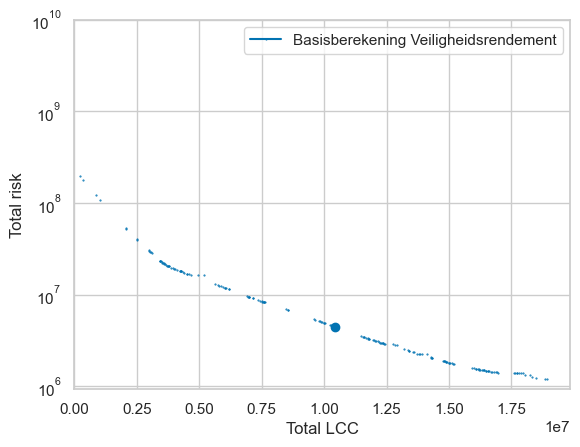

In [4]:
fig, ax = plt.subplots()
for run in optimization_steps.keys():
    plot_lcc_tc_from_steps(optimization_steps[run], axis=ax, lbl  = run, clr = colors[0])
    ax.plot(optimization_steps[run][minimal_tc_steps[run]]['total_lcc'], optimization_steps[run][minimal_tc_steps[run]]['total_risk'], 'o', color = colors.pop(0))
ax.set_xlabel('Total LCC')
ax.set_ylabel('Total risk')
ax.set_yscale('log')
ax.set_xlim(left=0)
ax.set_ylim(top=1e10)
ax.legend()
plt.savefig(database_path.parent.joinpath(f'{casename}_lcc_risk.png'),dpi=300,bbox_inches='tight')

Based on this graph we already get a good idea of which run leads to the most optimal solution (low risk - low cost).

### Reading measures per step
The next step is to read the measures and parameters of these measures for each optimization step such that we can compare the measures that are taken in each step and for each section.

In [5]:
lists_of_measures = {run['id']: get_measures_for_run_id(database_path, run['id']) for run in run_list}

measures_per_step = {run['id']: get_measures_per_step_number(lists_of_measures[run['id']]) for run in run_list}

If we want to see the failure probability per stap we first need to load the original assessment for each mechanism, and then we can compute the reliability for each step during the optimization. 

In [6]:
assessment_results = {mechanism: import_original_assessment(database_path, mechanism) 
                      for mechanism in [MechanismEnum.OVERFLOW, MechanismEnum.PIPING, MechanismEnum.STABILITY_INNER]}

reliability_per_step = {run['id']: get_reliability_for_each_step(database_path, measures_per_step[run['id']]) for run in run_list}

Based on these inputs we can make a stepwise_assessment based on the investments in reliability_per_step

In [7]:
stepwise_assessment = {run['id']: assessment_for_each_step(copy.deepcopy(assessment_results), reliability_per_step[run['id']]) for run in run_list}

In [8]:
print(stepwise_assessment)

{1: [{<MechanismEnum.OVERFLOW: 1>: {1: {'time': [0, 19, 20, 25, 50, 75, 100], 'beta': [4.553393506493507, 4.485881818181818, 4.482328571428572, 4.46456233766234, 4.3757311688311695, 4.2869, 4.198068831168833]}, 2: {'time': [0, 19, 20, 25, 50, 75, 100], 'beta': [4.553393506493507, 4.485881818181818, 4.482328571428572, 4.46456233766234, 4.3757311688311695, 4.2869, 4.198068831168833]}, 3: {'time': [0, 19, 20, 25, 50, 75, 100], 'beta': [4.376681818181819, 4.300509090909092, 4.2965, 4.276454545454545, 4.176227272727273, 4.076, 3.9757727272727283]}, 4: {'time': [0, 19, 20, 25, 50, 75, 100], 'beta': [4.62523116883117, 4.572327272727273, 4.569542857142857, 4.555620779220779, 4.486010389610391, 4.4164, 4.346789610389611]}, 5: {'time': [0, 19, 20, 25, 50, 75, 100], 'beta': [4.62523116883117, 4.572327272727273, 4.569542857142857, 4.555620779220779, 4.486010389610391, 4.4164, 4.346789610389611]}, 6: {'time': [0, 19, 20, 25, 50, 75, 100], 'beta': [4.625231168831172, 4.572327272727275, 4.56954285714

The next step is to derive the traject probability for each mechanism for each step using the `calculate_traject_probability_for_steps` function

In [9]:
traject_prob = {run['id']: calculate_traject_probability_for_steps(stepwise_assessment[run['id']]) for run in run_list}

for count, run in enumerate(run_list):
    print(traject_prob[run['id']][minimal_tc_steps[run['name']]])


{<MechanismEnum.OVERFLOW: 1>: {0: 2.244486981467377e-05, 100: 0.00013541632842700686, 75: 7.914169132520554e-05, 50: 5.177526375629467e-05, 19: 3.0972984132554564e-05, 20: 3.149771415155319e-05, 25: 3.4250030752859175e-05}, <MechanismEnum.PIPING: 3>: {0: 9.76256788269847e-05, 100: 0.0002750553105085318, 75: 0.0002066344877924564, 50: 0.00015658125625073183, 19: 0.00011488925773861514, 20: 0.00011595187478596891, 25: 0.0001215197598783968}, <MechanismEnum.STABILITY_INNER: 2>: {0: 2.4783444973697222e-05, 100: 2.4783444973697222e-05, 75: 2.4783444973697222e-05, 50: 2.4783444973697222e-05, 19: 2.4783444973697222e-05, 20: 2.4783444973697222e-05, 25: 2.4783444973697222e-05}}


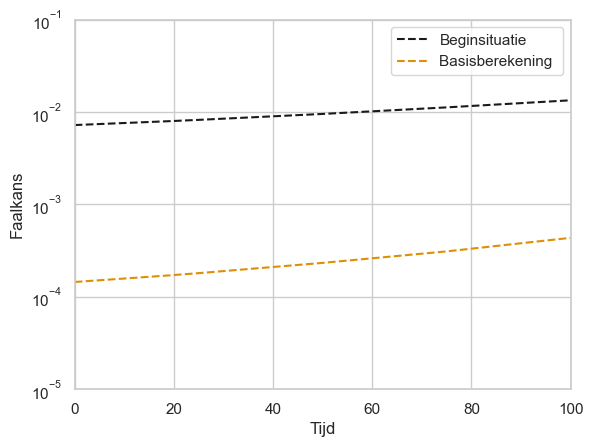

In [10]:
fig, ax  = plt.subplots()

plot_traject_probability_for_step(traject_prob[1][0], ax, run_label='Beginsituatie',color = 'k')
for count, run in enumerate(run_list):
    plot_traject_probability_for_step(traject_prob[run['id']][minimal_tc_steps[run['name']]], ax, run_label=run['name'].strip('Veiligheidsrendement'), color = colors[count])

ax.set_ylim(bottom = 1e-5, top = 1e-1)
ax.set_xlim(left = 0, right = 100)
plt.savefig(database_path.parent.joinpath(f'{casename}_traject_prob_in_time.png'),dpi=300,bbox_inches='tight')

Now we check the measures for each section. We print the ids of the measures

In [11]:
measures_per_section = {run['id']: get_measures_per_section_for_step(measures_per_step[run['id']], minimal_tc_steps[run['name']]) for run in run_list}
section_names = [list(measures_per_section[run].keys()) for run in measures_per_section.keys()]
section_names = list(set([item for sublist in section_names for item in sublist]))

for section in section_names:
    for run in measures_per_section.keys():
        try:
            print(f"Section {section} in run {run} has measures {measures_per_section[run][section][0]} at time {measures_per_section[run][section][1]}")  
        except:
            print(f"Section {section} in run {run} has no measures in run {run}")

Section 1 in run 1 has measures [217, 1] at time [0, 0]
Section 2 in run 1 has measures [438, 222] at time [0, 0]
Section 3 in run 1 has measures [659, 443] at time [0, 0]
Section 4 in run 1 has measures [880, 664] at time [0, 0]
Section 5 in run 1 has measures [1101, 885] at time [0, 0]
Section 6 in run 1 has measures [1322, 1106] at time [0, 0]
Section 7 in run 1 has measures [1543, 1327] at time [0, 0]
Section 11 in run 1 has measures [2427, 2211] at time [0, 0]
Section 12 in run 1 has measures [2648, 2432] at time [0, 0]
Section 15 in run 1 has measures [3311, 3095] at time [0, 0]
Section 20 in run 1 has measures [4205] at time [0]
Section 22 in run 1 has measures [4646] at time [0]
Section 24 in run 1 has measures [5089] at time [0]
Section 25 in run 1 has measures [5308] at time [0]
Section 26 in run 1 has measures [5532] at time [0]
Section 27 in run 1 has measures [5966] at time [0]
Section 28 in run 1 has measures [5972] at time [0]
Section 29 in run 1 has measures [6192] at t

Now we get for each section the parameters of the measure + timing + cost. This is stored in a `pd.DataFrame` for each run.

In [12]:
section_parameters = defaultdict(dict)

for run in measures_per_section.keys():
    for section in measures_per_section[run].keys():
        section_parameters[run][section] = []
        for measure in measures_per_section[run][section][0]:
            parameters = get_measure_parameters(measure, database_path)
            parameters.update(get_measure_costs(measure, database_path))
            parameters.update(get_measure_type(measure, database_path))
            section_parameters[run][section].append(parameters)

measure_parameters = {run['id']: measure_per_section_to_df(measures_per_section[run['id']], section_parameters[run['id']]) for run in run_list}


We list the investment for each year for each section

In [13]:
# we need final step of stepwise_assessment
# and assessment_results for initial state of each section
# we also have costs per section.

# determine final beta for traject:
initial_traject_probability_per_mechanism = calculate_traject_probability(assessment_results)
print(f"Final traject probability is {initial_traject_probability_per_mechanism}")

n_time_steps = len(initial_traject_probability_per_mechanism[MechanismEnum.OVERFLOW])
time_steps = initial_traject_probability_per_mechanism[MechanismEnum.OVERFLOW].keys()
print(f"Number of time steps is {n_time_steps}")
print(f"Time steps are {time_steps}")

initial_traject_probability = {time: sum([initial_traject_probability_per_mechanism[mechanism][time] for mechanism in initial_traject_probability_per_mechanism]) for time in time_steps}
print(initial_traject_probability)

# print final step of stepwise_assessment (at minimal_tc_steps):
for count, run in enumerate(run_list):
    final_traject_probability_per_mechanism = traject_prob[run['id']][minimal_tc_steps[run['name']]]
    final_section_probability_per_mechanism = stepwise_assessment[run['id']][minimal_tc_steps[run['name']]]
print(f"Final traject probability is {final_traject_probability_per_mechanism}")
final_traject_probability = {time: sum([final_traject_probability_per_mechanism[mechanism][time] for mechanism in final_traject_probability_per_mechanism]) for time in time_steps}
print(final_traject_probability)

Final traject probability is {<MechanismEnum.OVERFLOW: 1>: {0: 8.625642325360978e-05, 100: 0.0006495013452424325, 75: 0.0004023108390659708, 50: 0.0002449672824359944, 19: 0.00012929450525212818, 20: 0.00013204201587619678, 25: 0.0001466198539549501}, <MechanismEnum.PIPING: 3>: {0: 0.013009664252130904, 100: 0.02309309486654454, 75: 0.01988226167504592, 50: 0.017171891847211573, 19: 0.014412970462163277, 20: 0.014492556714083116, 25: 0.014899476451536886}, <MechanismEnum.STABILITY_INNER: 2>: {0: 0.00012919708498704274, 100: 0.00012919708498704274, 75: 0.00012919708498704274, 50: 0.00012919708498704274, 19: 0.00012919708498704274, 20: 0.00012919708498704274, 25: 0.00012919708498704274}}
Number of time steps is 7
Time steps are dict_keys([0, 100, 75, 50, 19, 20, 25])
{0: 0.013225117760371555, 100: 0.023871793296774014, 75: 0.020413769599098935, 50: 0.01754605621463461, 19: 0.014671462052402448, 20: 0.014753795814946355, 25: 0.01517529339047888}
Final traject probability is {<MechanismEnu

In [14]:
# read from the database the economic damage, which is found in DikeTrajectInfo, and called flood_damage
# there is only 1 value in total, so we can use the first value

with open_database(database_path) as db:
    damage = DikeTrajectInfo.select(DikeTrajectInfo.flood_damage).where(DikeTrajectInfo.id == 1).get().flood_damage

print(f"Damage is {damage}")

Damage is 700000000.0


In [15]:
from scipy.interpolate import interp1d

for key in final_traject_probability_per_mechanism.keys():
    times,betas = zip(*final_traject_probability_per_mechanism[key].items())
    time_beta_interpolation = interp1d(times, betas, kind='linear', fill_value='extrapolate')
    final_traject_probability_per_mechanism[key] = time_beta_interpolation(list(range(0,100)))
    #reshape too [1,100]\
    final_traject_probability_per_mechanism[key] = np.array(final_traject_probability_per_mechanism[key]).reshape(1,100)


In [16]:
discount_rate = 0.03

damage_per_year = np.divide(damage, np.power(1+discount_rate, np.arange(0,100)))
#reshape to [1,100]
damage_per_year = damage_per_year.reshape(1,100)
print(damage_per_year)

[[7.00000000e+08 6.79611650e+08 6.59817136e+08 6.40599162e+08
  6.21940934e+08 6.03826149e+08 5.86238980e+08 5.69164058e+08
  5.52586464e+08 5.36491713e+08 5.20865740e+08 5.05694894e+08
  4.90965916e+08 4.76665938e+08 4.62782464e+08 4.49303363e+08
  4.36216857e+08 4.23511512e+08 4.11176225e+08 3.99200219e+08
  3.87573028e+08 3.76284493e+08 3.65324751e+08 3.54684224e+08
  3.44353615e+08 3.34323898e+08 3.24586309e+08 3.15132339e+08
  3.05953727e+08 2.97042454e+08 2.88390732e+08 2.79991002e+08
  2.71835924e+08 2.63918373e+08 2.56231430e+08 2.48768378e+08
  2.41522698e+08 2.34488056e+08 2.27658307e+08 2.21027482e+08
  2.14589789e+08 2.08339601e+08 2.02271457e+08 1.96380055e+08
  1.90660248e+08 1.85107037e+08 1.79715570e+08 1.74481135e+08
  1.69399161e+08 1.64465205e+08 1.59674956e+08 1.55024229e+08
  1.50508960e+08 1.46125204e+08 1.41869130e+08 1.37737020e+08
  1.33725262e+08 1.29830351e+08 1.26048885e+08 1.22377558e+08
  1.18813163e+08 1.15352585e+08 1.11992801e+08 1.08730875e+08
  1.0556

In [23]:
#compute probability of failure from final_traject_probability_per_mechanism
total_non_failure_probability = np.ones([1,100])
for key in final_traject_probability_per_mechanism.keys():
    total_non_failure_probability = np.multiply(total_non_failure_probability, 1-final_traject_probability_per_mechanism[key])
total_failure_probability = 1 - total_non_failure_probability

#compute expected damage per year
expected_damage_per_year = np.multiply(damage_per_year, total_failure_probability)

#print total damage
total_damage = np.sum(expected_damage_per_year)
print(f"Total damage is {total_damage}")

Total damage is 4470095.453358142


In [21]:
total_non_failure_probability

array([], shape=(0, 100), dtype=float64)

In [ ]:
# stepwise_assessment: final_section_probability_per_mechanism

# section by section, replace the final traject probability by the initial traject probability of that section
# then recalculate the traject failure probability. 

# create empty lists
increase_in_traject_risk = []
section_costs = []

# create empty dictionary
vr_index = {}

t = 25 # 25 years from now +- 2050

# create an empty dictionary to store the final section probability per mechanism

for section in section_names:
    final_section_probability_per_mechanism_temp = copy.deepcopy(final_section_probability_per_mechanism)
    print(final_section_probability_per_mechanism_temp)
    final_traject_probability_temp = copy.deepcopy(final_traject_probability)
    print(final_traject_probability_temp)

    for mechanism in assessment_results.keys():
        print("section =", section)
        print("mechanism =", mechanism)
        final_section_probability_per_mechanism_temp[mechanism][section]['beta'] = assessment_results[mechanism][section]['beta']

    # recalculate final traject probability
    final_traject_probability_per_mechanism_temp = calculate_traject_probability(final_section_probability_per_mechanism_temp)
    final_traject_probability_temp = {time: sum([final_traject_probability_per_mechanism_temp[mechanism][time] for mechanism in final_traject_probability_per_mechanism_temp]) for time in time_steps}
    print(f"Final traject probability for section {section} is {final_traject_probability_temp}")
    print(section)
    if section in list(measure_parameters[1]['section_id']):
        print(f"Section {section} is in the list of sections with measures")
        increase_in_traject_failure_probability = final_traject_probability_temp[t] - final_traject_probability[t]
        increase_in_traject_risk = increase_in_traject_failure_probability * damage
        section_costs = measure_parameters[1][measure_parameters[1]['section_id'] == section]['LCC'].values[0]
        vr_index[section] = increase_in_traject_risk / section_costs
    else:
        print(f"Section {section} is not in the list of sections with measures")
        vr_index[section] = 0
    # calculate the increase in traject failure probability at time t
    # increase_in_traject_failure_probability = final_traject_probability_temp[t] - final_traject_probability[t]
    # print(f"Increase in traject failure probability for section {section} is {increase_in_traject_failure_probability}")
    # print(f"Risk increase is {increase_in_traject_failure_probability * damage}")
    # increase_in_traject_risk.append(increase_in_traject_failure_probability * damage)

    # # section costs = where measure_parameters[1]['section_id'] == section, we need the value in LCC column 
    # section_costs = measure_parameters[1][measure_parameters[1]['section_id'] == section]['LCC']


{<MechanismEnum.OVERFLOW: 1>: {1: {'time': [0, 19, 20, 25, 50, 75, 100], 'beta': [4.553393506493508, 4.485881818181818, 4.482328571428572, 4.4645623376623425, 4.3757311688311695, 4.2869, 4.20162207792208]}, 2: {'time': [0, 19, 20, 25, 50, 75, 100], 'beta': [4.553393506493508, 4.485881818181818, 4.482328571428572, 4.4645623376623425, 4.3757311688311695, 4.2869, 4.20162207792208]}, 3: {'time': [0, 19, 20, 25, 50, 75, 100], 'beta': [4.376681818181821, 4.300509090909093, 4.2965, 4.276454545454545, 4.176227272727273, 4.076, 3.9797818181818188]}, 4: {'time': [0, 19, 20, 25, 50, 75, 100], 'beta': [4.625231168831172, 4.572327272727275, 4.569542857142857, 4.555620779220779, 4.486010389610393, 4.4164, 4.349574025974027]}, 5: {'time': [0, 19, 20, 25, 50, 75, 100], 'beta': [4.625231168831172, 4.572327272727275, 4.569542857142857, 4.555620779220779, 4.486010389610393, 4.4164, 4.349574025974027]}, 6: {'time': [0, 19, 20, 25, 50, 75, 100], 'beta': [4.625231168831172, 4.572327272727275, 4.569542857142

In [ ]:
print(vr_index)

# sort the dictionary by value
sorted_vr_index = dict(sorted(vr_index.items(), key=lambda item: item[1], reverse=True))
print(sorted_vr_index)

# write the results to a csv file
df = pd.DataFrame(sorted_vr_index.items(), columns=['Section', 'VR index'])
df.to_csv(database_path.parent.joinpath(f'vr_index.csv'), index=False)

{1: 2.8228825907003534, 2: 0.4308149703612637, 3: 3.114804286408931, 4: 0.03524580588550518, 5: 0.5309295529526025, 6: 17.91994672802317, 7: 0.03769091489304325, 11: 0.7173000133057496, 12: 0.3772519558464382, 15: 1.454458599236935, 20: 0.08118946962506539, 22: 0.07276589931723401, 24: 0.18701343363263329, 25: 0.05806775159951624, 26: 0.326620619931512, 27: 0.12984005334280843, 28: 0.15973488502316333, 29: 0.07767788171705245, 30: 0.07776273371100736, 31: 0.6742459404380641, 32: 0.10716734646954895, 33: 0.23525192232938494, 34: 0.22124907160766824, 35: 0.16456733927696066, 36: 0.23262899720819977, 37: 0.0833100534143061, 38: 0.04485901306200667, 39: 0.29666865509566454, 40: 0.03172482541755535, 41: 0.08945364816430347}
{6: 17.91994672802317, 3: 3.114804286408931, 1: 2.8228825907003534, 15: 1.454458599236935, 11: 0.7173000133057496, 31: 0.6742459404380641, 5: 0.5309295529526025, 2: 0.4308149703612637, 12: 0.3772519558464382, 26: 0.326620619931512, 39: 0.29666865509566454, 33: 0.23525192